# 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
import sys
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 2. Preparation of the Data

## 2.1 Defining Test Ratio

In [2]:
# Defines how many percent of the data is used to train and test the models. Here we use 20% of the data for testing

In [3]:
test_ratio=0.2

## 2.2 Columns with attributes 

In [4]:
#t = temperature
t_attributeslist=["TYYMIN6190","TYYMEAN6190","TYYMAX6190","TOCTMIN6190","TOCTMEAN6190","TOCTMAX6190","TJULMIN6190","TJULMEAN6190","TJULMAX6190","TJANMIN6190","TJANMEAN6190","TJANMAX6190","TAPRMIN6190","TAPRMEAN6190","TAPRMAX6190","TABSMIN","TABSMAX"]

#kont = thermal continentality
kont_attributeslist=["KONTYY1800","KONTYY1400","KONTYY1000","KONTYY","KONTOCT2000","KONTOCT1800","KONTOCT1400","KONTOCT1000","KONTOCT","KONTJUL2000","KONTJUL1800","KONTJUL1400","KONTJUL1000","KONTJUL","KONTJAN2000","KONTJAN1800","KONTJAN1400","KONTJAN1000","KONTJAN","KONTJAHR2000","KONTAPR2000","KONTAPR1800","KONTAPR1400","KONTAPR1000","KONTAPR","KONTABS2000","KONTABS1000","KONTABS"]

#foehnh = foehn wind frequency
foehnh_attributeslist=["FOEHNHYY","FOEHNHOCT","FOEHNHJUL","FOEHNHJAN","FOEHNHAPR"]

#ns = precipitation = rnorm
ns_attributeslist=["RNORMJAN6190","RNORMFEB6190", "RNORMMAR6190","RNORMAPR6190","RNORMMAY6190","RNORMJUN6190","RNORMJUL6190","RNORMAUG6190","RNORMSEP6190","RNORMOCT6190","RNORMNOV6190","RNORMDEC6190","RNORMYY6190","RNORMJJA6190","RNORMAMJJA6190","RNORMAMJJAS6190"]

#rad = global radiation
rad_attributeslist=["GLOBRADYYW","GLOBRADJULW","GLOBRADJANW","GLOBRADAPRW", "GLOBRADOCTW"]

#lf = relative air moisture
lf_attributeslist=["MLFYY","MLFOCT","MLFJUL","MLFJAN","MLFAPR","LFOCT","LFJUL","LFJAN","LFAPR","LFYY"]

## 2.2 Splitting of data

In [5]:
# Spliting the data into train and test groups with the defined ratio

In [6]:
def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

## 2.3 Import data from csv

In [7]:
samples_n_df=pd.read_csv('samples_n_6190.csv', sep=';')

## 2.4 Extract, clean, split and scale data of different belts

In [8]:
vegetation_belts=[]
belt = "samples_belt_"


for belt_n in range(1,7):
    current_belt = belt+str(belt_n)
    current_belt_all_df=[]
    
    
    # Extract vegetation belt n
    samples_df=samples_n_df[samples_n_df.HSMAX==belt_n]
    samples_df=samples_df.assign(CLASS=1)

    # Clean the data with missing values 
    imp=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(samples_df)

    samples_dfclean=pd.DataFrame(imp.transform(samples_df), columns=samples_df.columns)


    # Split data in training set and test set
    trainset, testset=split_train_test(samples_dfclean, test_ratio)


    # Transform and scale the data
    num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("std_scaler", StandardScaler()),])
    full_pipeline=FeatureUnion(transformer_list=[("num_pipeline", num_pipeline)])
    trainset_prepared=full_pipeline.fit_transform(trainset)
    trainset_prepared_df=pd.DataFrame(trainset_prepared, columns=testset.columns)
    testset_prepared=full_pipeline.fit_transform(testset)
    testset_prepared_df=pd.DataFrame(testset_prepared, columns=testset.columns)

    # Saving the data from all belts for training and testing
    current_belt_all_df.append(trainset_prepared_df)
    current_belt_all_df.append(trainset)
    current_belt_all_df.append(testset_prepared_df)
    current_belt_all_df.append(testset)
    
    # Append the belts
    vegetation_belts.append(current_belt_all_df)
    



# 3. Regressor Models

## 3.1 Defining values

In [9]:
# extract the values for every month and year

In [10]:
jan_X=["RNORMJAN6190","KONTJAN","ETAETP","FOEHNHJAN","GLOBRADJANW"]
jan_Y=["TJANMEAN6190"]

apr_X=["RNORMAPR6190","KONTAPR","ETAETP","FOEHNHAPR","GLOBRADAPRW"]
apr_Y=["TAPRMEAN6190"]

jul_X=["RNORMJUL6190","KONTJUL","ETAETP","FOEHNHJUL","GLOBRADJULW"]
jul_Y=["TJULMEAN6190"]

oct_X=["RNORMOCT6190","KONTOCT","ETAETP","FOEHNHOCT","GLOBRADOCTW"]
oct_Y=["TOCTMEAN6190"]

YY_X=["RNORMYY6190","KONTYY","ETAETP","FOEHNHYY","GLOBRADYYW"]
YY_Y=["TYYMEAN6190"]

## 3.2 Defining x and y 

In [11]:
# Define the x and y test and train data

In [12]:
def get_XY_from_specific_time(x, y, df, hsmax):
        
    Xtrain= df[hsmax][0][ x ].to_numpy()
    ytrain= df[hsmax][1][ y ].values.reshape(-1)

    Xtest = df[hsmax][2][ x ].to_numpy()
    ytest = df[hsmax][3][ y ].values.reshape(-1)
    
    return Xtrain, ytrain, Xtest, ytest

## 3.3 Training of the Models 

In [13]:
# Training the four models with the train dataset
# The models are: linear regressor, random forest regressor, extra tree regressor and decision tree regressor

In [14]:
def train_Regressor_Models(x_train,y_train):
    
    lin_model=LinearRegression()
    lin_model.fit(x_train,y_train) # Trains linear Regressor
    
    rfg_model=RandomForestRegressor()
    rfg_model.fit(x_train,y_train) # Trains Random Forest Regressor
    
    etr_model=ExtraTreesRegressor()
    etr_model.fit(x_train,y_train) # Trains Extra Trees Regressor
    
    dtr_model=DecisionTreeRegressor()
    dtr_model.fit(x_train,y_train) # Trains Decision Tree Regressor
    
    return lin_model, rfg_model, etr_model, dtr_model

## 3.4 Testing of the Models and calculating the RMSE

In [15]:
# Tests the models with the test dataset and calculates the RMSE

In [16]:
def test_Regressor_Models(model,x_test,y_test):
    
    prediction=model.predict(x_test)
    model_rmse=mean_squared_error(y_test,prediction, squared=False)
    
    return model_rmse

## 3.5 Definition of the evaluation set

In [17]:
evaluation_set = [ ["January" ,jan_X, jan_Y] , ["April" ,apr_X, apr_Y] , ["July", jul_X, jul_Y] , ["October", oct_X, oct_Y], ["Year", YY_X, YY_Y]]

# 4. Results

## 4.1 Running models and return csv

In [18]:
# Running of the models for all months of each belt and return the RMSE of each in a csv

In [19]:
data = {}
for month in evaluation_set: 
    data['lr'+'-'+month[0]]=[]
    data['rfg'+'-'+month[0]]=[]
    data['etr'+'-'+month[0]]=[]
    data['dtr'+'-'+month[0]]=[]



for belt in range(0,6):
    print("#########    Starting Belt "+str(belt+1)+"      #########  ")
    for month in evaluation_set:

        # Split data for month into x/y
        x_Tr , y_Tr , x_Te , y_Te = get_XY_from_specific_time( month[1]  , month[2], vegetation_belts , belt )

        # Training model with data of month
        lin_model, rfg_model, etr_model, dtr_model = train_Regressor_Models(x_Tr, y_Tr)

        # Test model
        lr_rmse = test_Regressor_Models(lin_model, x_Te, y_Te)
        rfg_rmse = test_Regressor_Models(rfg_model, x_Te, y_Te)
        etr_rmse = test_Regressor_Models(etr_model, x_Te, y_Te)
        dtr_rmse = test_Regressor_Models(dtr_model, x_Te, y_Te)
        
        
        # Saves the RMSE in a array for df anad csv use
        data['lr'+'-'+month[0]].append(lr_rmse)
        data['rfg'+'-'+month[0]].append(rfg_rmse)
        data['etr'+'-'+month[0]].append(etr_rmse)
        data['dtr'+'-'+month[0]].append(dtr_rmse)
        
    print("#             Belt "+str(belt+1)+" done                 #  ")
        


df = pd.DataFrame(data)
df.to_csv('vegetation_belt_results.csv')

#########    Starting Belt 1      #########  
#             Belt 1 done                 #  
#########    Starting Belt 2      #########  
#             Belt 2 done                 #  
#########    Starting Belt 3      #########  
#             Belt 3 done                 #  
#########    Starting Belt 4      #########  
#             Belt 4 done                 #  
#########    Starting Belt 5      #########  
#             Belt 5 done                 #  
#########    Starting Belt 6      #########  
#             Belt 6 done                 #  


## 4.2 Bar Plot for visualisation of results

In [20]:
# Transpose the data of the data frame

In [21]:
df_t = df.transpose()

In [22]:
# Creating a bar plot by using the RMSE of each model for every months/year of all belts
# Since it is sorted after index the order of the months is incorrect. 
# dtr= decision tree regressor, etr = extra tree regressor, lr= linear regressor, rfg= random forest regressor

Text(0, 0.5, 'RMSE')

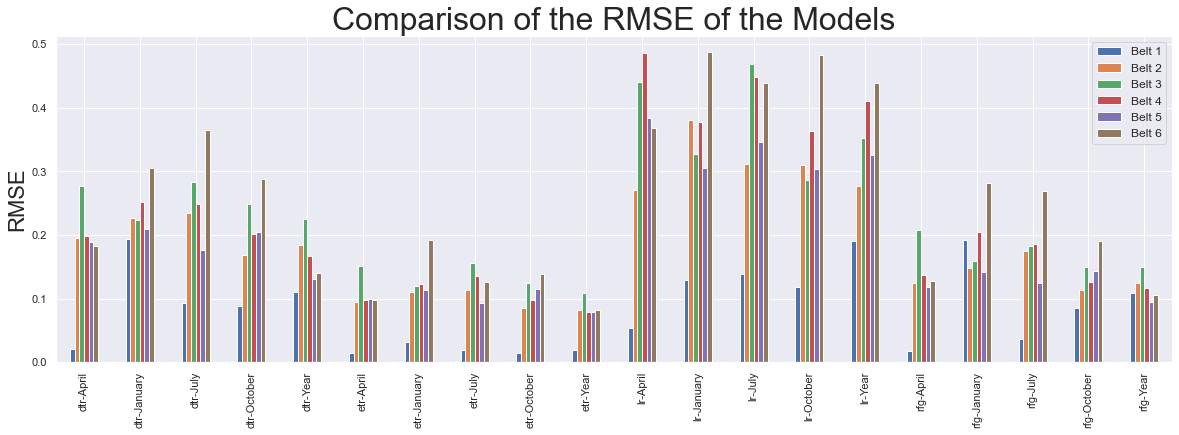

In [23]:
df_t.sort_index().plot.bar(figsize=(20, 6))
plt.legend(["Belt 1","Belt 2","Belt 3","Belt 4", "Belt 5", "Belt 6"], loc=1,ncol=1, fontsize=12)
plt.title("Comparison of the RMSE of the Models", fontsize=32)
plt.ylabel("RMSE", fontsize = 22)